Blockhouse Work Trial - Question 1: Temporary Impact Function Analysis

This script analyzes market microstructure data to determine the most robust 
functional form for the temporary impact function g_t(x), combining both
snapshot-based analysis and order book reconstruction capabilities.

Author: Leo Xu
Date: 07/28/2025

In [13]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict, OrderedDict
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# CONFIGURATION
# --------------------------
DATA_DIR = r"C:\Users\admin\Downloads\SOUN"  # Directory containing all CSV files
FILE_PATTERN = "*.csv"  # Pattern to match your files (adjust as needed)
X_GRID = list(range(100, 10001, 100))  # Test sizes from 100 to 10,000 shares
MIN_OBSERVATIONS_PER_SIZE = 15  # Minimum observations needed per order size
MAX_LEVELS = 10
# Analysis settings
SAMPLES_PER_DAY = 300  # Number of snapshots to analyze per day
SNAPSHOT_INTERVAL = 1000  # For message data: snapshot every N messages
MAX_LEVELS = 10  # Maximum order book levels to consider

Based on different types of orders in the level2 data, we reconstruct the order book for analyzing the model for temporary impact later.

In [ ]:
class OrderBook:
    """Reconstructs order book state from message-level data"""
    
    def __init__(self):
        self.bids = defaultdict(lambda: OrderedDict())  # price -> {order_id: size}
        self.asks = defaultdict(lambda: OrderedDict())  # price -> {order_id: size}
        self.order_locations = {}  # order_id -> (side, price)
        self.last_timestamp = None
        
    def clear(self):
        """Clear the entire order book"""
        self.bids.clear()
        self.asks.clear()
        self.order_locations.clear()
        
    def add_order(self, order_id, side, price, size, timestamp=None):
        """Add a new resting order to the book"""
        if size <= 0:
            return
            
        price, size = float(price), float(size)
        self.last_timestamp = timestamp
        self.order_locations[order_id] = (side, price)
        
        if side.upper() in ['B', 'BID', 'BUY']:
            self.bids[price][order_id] = size
        elif side.upper() in ['A', 'ASK', 'SELL']:
            self.asks[price][order_id] = size
            
    def cancel_order(self, order_id, cancel_size=None, timestamp=None):
        """Cancel some or all of an order's shares"""
        if order_id not in self.order_locations:
            return
            
        side, price = self.order_locations[order_id]
        self.last_timestamp = timestamp
        
        book_side = self.bids if side.upper() in ['B', 'BID', 'BUY'] else self.asks
            
        if price in book_side and order_id in book_side[price]:
            current_size = book_side[price][order_id]
            
            if cancel_size is None or cancel_size >= current_size:
                del book_side[price][order_id]
                del self.order_locations[order_id]
                if not book_side[price]:
                    del book_side[price]
            else:
                book_side[price][order_id] = current_size - cancel_size
                
    def get_book_levels(self, max_levels=10):
        """Get ordered book levels (bids high to low, asks low to high)"""
        sorted_bid_prices = sorted(self.bids.keys(), reverse=True)[:max_levels]
        sorted_ask_prices = sorted(self.asks.keys())[:max_levels]
        
        bids = [(price, sum(self.bids[price].values())) 
                for price in sorted_bid_prices 
                if sum(self.bids[price].values()) > 0]
        
        asks = [(price, sum(self.asks[price].values())) 
                for price in sorted_ask_prices 
                if sum(self.asks[price].values()) > 0]
                
        return bids, asks
        
    def process_message(self, message_type, order_id, side, price, size, timestamp=None):
        """Process a single order book message"""
        message_type = message_type.upper()
        
        if message_type in ['ADD', 'A']:
            self.add_order(order_id, side, price, size, timestamp)
        elif message_type in ['CANCEL', 'C', 'REMOVE']:
            self.cancel_order(order_id, size, timestamp)
        elif message_type in ['CLEAR', 'RESET']:
            self.clear()

Data loading and pick the prices and sizes we need from the data.

In [8]:
def detect_data_format(file_path):
    """Detect if data contains messages or snapshots"""
    try:
        df_sample = pd.read_csv(file_path, nrows=100)
        
        # Check for message-level columns
        has_message_type = any('type' in col.lower() or 'msg' in col.lower() for col in df_sample.columns)
        has_order_id = any('order' in col.lower() and 'id' in col.lower() for col in df_sample.columns)
        
        # Check for snapshot-level columns  
        has_bid_levels = any('bid_px' in col.lower() or 'bid_price' in col.lower() for col in df_sample.columns)
        has_ask_levels = any('ask_px' in col.lower() or 'ask_price' in col.lower() for col in df_sample.columns)
        
        if has_message_type and has_order_id:
            return 'message'
        elif has_bid_levels and has_ask_levels:
            return 'snapshot'
        else:
            return 'unknown'
    except Exception as e:
        print(f"Error detecting format for {file_path}: {e}")
        return 'unknown'


# Find all CSV files
csv_files = glob.glob(os.path.join(DATA_DIR, FILE_PATTERN))
csv_files.sort()

print(f"✓ Found {len(csv_files)} CSV files:")
for file in csv_files[:5]:  # Show first 5 files
    print(f"  - {os.path.basename(file)}")
if len(csv_files) > 5:
    print(f"  ... and {len(csv_files) - 5} more files")

if len(csv_files) == 0:
    print("❌ No CSV files found! Check DATA_DIR and FILE_PATTERN")
    exit()

# Detect data format and load files
all_data = []
data_format = None
total_records = 0

for file_path in csv_files:
    filename = os.path.basename(file_path)
    print(f"\nProcessing {filename}...")
    
    try:
        # Detect format from first file
        if data_format is None:
            data_format = detect_data_format(file_path)
            print(f"  ✓ Detected data format: {data_format}")
        
        # Load based on format
        if data_format == 'snapshot':
            df = pd.read_csv(file_path, parse_dates=["ts_event"])
            timestamp_col = 'ts_event'
        else:
            df = pd.read_csv(file_path)
            # Try to identify timestamp column
            timestamp_col = None
            for col in df.columns:
                if 'time' in col.lower() or 'ts' in col.lower():
                    timestamp_col = col
                    break
            if timestamp_col is None:
                timestamp_col = df.columns[0]  # Assume first column
            
            df[timestamp_col] = pd.to_datetime(df[timestamp_col])
        
        # Add metadata
        df['date'] = df[timestamp_col].dt.date
        df['file_source'] = filename
        
        all_data.append(df)
        total_records += len(df)
        
        print(f"  ✓ {len(df):,} records from {df[timestamp_col].min().date()} to {df[timestamp_col].max().date()}")
        
    except Exception as e:
        print(f"  ❌ Error loading {file_path}: {e}")
        continue

if not all_data:
    print("❌ No data loaded successfully!")
    exit()

✓ Found 21 CSV files:
  - SOUN_2025-04-03 00_00_00+00_00.csv
  - SOUN_2025-04-04 00_00_00+00_00.csv
  - SOUN_2025-04-07 00_00_00+00_00.csv
  - SOUN_2025-04-08 00_00_00+00_00.csv
  - SOUN_2025-04-09 00_00_00+00_00.csv
  ... and 16 more files

Processing SOUN_2025-04-03 00_00_00+00_00.csv...
  ✓ Detected data format: snapshot
  ✓ 362,850 records from 2025-04-03 to 2025-04-03

Processing SOUN_2025-04-04 00_00_00+00_00.csv...
  ✓ 229,248 records from 2025-04-04 to 2025-04-04

Processing SOUN_2025-04-07 00_00_00+00_00.csv...
  ✓ 462,018 records from 2025-04-07 to 2025-04-07

Processing SOUN_2025-04-08 00_00_00+00_00.csv...
  ✓ 244,436 records from 2025-04-08 to 2025-04-08

Processing SOUN_2025-04-09 00_00_00+00_00.csv...
  ✓ 749,204 records from 2025-04-09 to 2025-04-09

Processing SOUN_2025-04-10 00_00_00+00_00.csv...
  ✓ 321,238 records from 2025-04-10 to 2025-04-10

Processing SOUN_2025-04-11 00_00_00+00_00.csv...
  ✓ 183,500 records from 2025-04-11 to 2025-04-11

Processing SOUN_2025-04

Combine all data together

In [9]:
print(f"\nCombining data from {len(all_data)} files...")
combined_df = pd.concat(all_data, ignore_index=True)
combined_df = combined_df.sort_values(timestamp_col).reset_index(drop=True)

print(f"✓ Total combined data: {total_records:,} records")
print(f"✓ Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
print(f"✓ Trading days: {combined_df['date'].nunique()}")

if data_format == 'message':
    print("\n2. RECONSTRUCTING ORDER BOOK FROM MESSAGES")
    print("-" * 40)
    
    # Try to auto-detect column names
    column_mapping = {'timestamp': timestamp_col}
    
    for col in combined_df.columns:
        col_lower = col.lower()
        if 'type' in col_lower and 'message_type' not in column_mapping:
            column_mapping['message_type'] = col
        elif 'order' in col_lower and 'id' in col_lower:
            column_mapping['order_id'] = col
        elif col_lower in ['side', 'direction']:
            column_mapping['side'] = col
        elif 'price' in col_lower or 'px' in col_lower:
            column_mapping['price'] = col
        elif 'size' in col_lower or 'qty' in col_lower:
            column_mapping['size'] = col
    
    print("Column mapping attempt:")
    for key, val in column_mapping.items():
        print(f"  {key}: {val}")
    
    # Check if we have required columns for reconstruction
    required_cols = ['message_type', 'order_id', 'side', 'price', 'size']
    missing_cols = [k for k in required_cols if k not in column_mapping]
    
    if missing_cols:
        print(f"⚠ Missing columns {missing_cols}, treating as snapshot data")
        data_format = 'snapshot'
    else:
        print("✓ Reconstructing order book...")
        
        # Process messages and create snapshots
        order_book = OrderBook()
        snapshot_data = []
        
        for idx, row in combined_df.head(50000).iterrows():  # Limit for demo
            if idx % 5000 == 0:
                print(f"  Processing message {idx:,}...")
            
            try:
                timestamp = row[column_mapping['timestamp']]
                message_type = str(row[column_mapping['message_type']])
                order_id = str(row[column_mapping['order_id']])
                side = str(row[column_mapping['side']])
                price = float(row[column_mapping['price']])
                size = float(row[column_mapping['size']])
                
                order_book.process_message(message_type, order_id, side, price, size, timestamp)
                
                # Take periodic snapshots
                if idx % SNAPSHOT_INTERVAL == 0:
                    bids, asks = order_book.get_book_levels()
                    if len(bids) >= 2 and len(asks) >= 2:
                        snapshot_data.append({
                            'ts_event': timestamp,
                            'date': row['date'],
                            'file_source': row['file_source'],
                            'bids': bids,
                            'asks': asks
                        })
            except Exception as e:
                continue
        
        # Convert to snapshot format
        reconstructed_data = []
        for snapshot in snapshot_data:
            row_data = {
                'ts_event': snapshot['ts_event'],
                'date': snapshot['date'],
                'file_source': snapshot['file_source']
            }
            
            # Add bid/ask levels
            for i, (price, size) in enumerate(snapshot['bids'][:MAX_LEVELS]):
                row_data[f'bid_px_{i:02d}'] = price
                row_data[f'bid_sz_{i:02d}'] = size
            
            for i, (price, size) in enumerate(snapshot['asks'][:MAX_LEVELS]):
                row_data[f'ask_px_{i:02d}'] = price
                row_data[f'ask_sz_{i:02d}'] = size
            
            reconstructed_data.append(row_data)
        
        combined_df = pd.DataFrame(reconstructed_data)
        print(f"✓ Created {len(combined_df)} order book snapshots")


Combining data from 21 files...
✓ Total combined data: 5,505,097 records
✓ Date range: 2025-04-03 to 2025-05-02
✓ Trading days: 21


Use regression to test each model(Linear,Square Root,Power Law,Quadratic,Logarithmic) for the function 

In [10]:
def extract_order_book(row, max_levels=MAX_LEVELS):
    """Extract and validate order book levels from market data"""
    bids, asks = [], []
    
    for i in range(max_levels):
        # Bid side
        bid_px = row.get(f'bid_px_{i:02d}')
        bid_sz = row.get(f'bid_sz_{i:02d}')
        if pd.notna(bid_px) and pd.notna(bid_sz) and bid_px > 0 and bid_sz > 0:
            bids.append((float(bid_px), float(bid_sz)))
        
        # Ask side  
        ask_px = row.get(f'ask_px_{i:02d}')
        ask_sz = row.get(f'ask_sz_{i:02d}')
        if pd.notna(ask_px) and pd.notna(ask_sz) and ask_px > 0 and ask_sz > 0:
            asks.append((float(ask_px), float(ask_sz)))
    
    # Sort: bids high→low, asks low→high
    bids.sort(reverse=True)
    asks.sort()
    
    return bids, asks

def calculate_temporary_impact(order_size, asks, mid_price):
    """
    Calculate temporary impact g_t(x) for a market buy order.
    
    This simulates walking through the ask-side order book to fill a market order,
    calculating the volume-weighted average price (VWAP) and comparing it to 
    the mid-price to get the temporary impact.
    """
    if not asks or order_size <= 0:
        return None
    
    remaining_size = order_size
    total_cost = 0.0
    levels_consumed = 0
    
    for price, available_size in asks:
        if remaining_size <= 0:
            break
            
        executed_size = min(available_size, remaining_size)
        total_cost += executed_size * price
        remaining_size -= executed_size
        levels_consumed += 1
    
    if remaining_size > 0:
        return None  # Insufficient liquidity in the book
    
    vwap = total_cost / order_size
    temporary_impact = vwap - mid_price
    
    return temporary_impact

# --------------------------
# IMPACT ANALYSIS
# --------------------------
section_num = 3 if data_format == 'message' else 2
print(f"\n{section_num}. CALCULATING TEMPORARY IMPACT ACROSS ALL DATA")
print("-" * 40)

# Stratified sampling by day
sample_data = []
total_snapshots = 0

for date in sorted(combined_df['date'].unique()):
    day_data = combined_df[combined_df['date'] == date]
    
    if len(day_data) > SAMPLES_PER_DAY:
        # Take samples at regular intervals throughout the trading day
        indices = np.linspace(0, len(day_data)-1, SAMPLES_PER_DAY, dtype=int)
        day_sample = day_data.iloc[indices]
    else:
        day_sample = day_data
    
    sample_data.append(day_sample)
    total_snapshots += len(day_sample)
    print(f"✓ {date}: {len(day_sample)} snapshots")

sample_df = pd.concat(sample_data, ignore_index=True)
print(f"\n✓ Total snapshots for analysis: {total_snapshots:,}")

# Calculate impact across all order sizes
print("\nCalculating temporary impact g_t(x)...")
impact_data = []
valid_snapshots = 0

for idx, (_, row) in enumerate(sample_df.iterrows()):
    if idx % 1000 == 0:
        print(f"  Progress: {idx:,}/{len(sample_df):,} ({100*idx/len(sample_df):.1f}%)")
    
    bids, asks = extract_order_book(row)
    
    if len(bids) < 2 or len(asks) < 2:
        continue
    
    best_bid, best_ask = bids[0][0], asks[0][0]
    mid_price = (best_bid + best_ask) / 2
    spread = best_ask - best_bid
    
    # Skip if spread is too wide (likely data issue)
    if spread > mid_price * 0.01:  # Skip if spread > 1%
        continue
    
    valid_snapshots += 1
    
    # Calculate impact for different order sizes
    for order_size in X_GRID:
        impact = calculate_temporary_impact(order_size, asks, mid_price)
        if impact is not None and impact >= 0:  # Only keep positive impacts
            impact_data.append({
                'timestamp': row['ts_event'],
                'date': row['date'],
                'order_size': order_size,
                'impact': impact,
                'impact_bps': (impact / mid_price) * 10000,
                'mid_price': mid_price,
                'spread_bps': (spread / mid_price) * 10000,
                'file_source': row['file_source']
            })

impact_df = pd.DataFrame(impact_data)
print(f"\n✓ Calculated {len(impact_data):,} impact observations")
print(f"✓ From {valid_snapshots:,} valid order book snapshots")
print(f"✓ Across {impact_df['date'].nunique()} trading days")
print(f"✓ Order sizes: {impact_df['order_size'].nunique()} different sizes")

if len(impact_data) == 0:
    print("❌ No valid impact data calculated! Check your data format.")
    exit()

# --------------------------
# MODEL DEFINITIONS
# --------------------------
def fit_impact_model(X_values, y_values, model_type):
    """Fit different functional forms to the temporary impact data"""
    
    X_values = np.array(X_values)
    y_values = np.array(y_values)
    
    # Remove any infinite or NaN values
    mask = np.isfinite(X_values) & np.isfinite(y_values) & (X_values > 0) & (y_values > 0)
    X_clean = X_values[mask]
    y_clean = y_values[mask]
    
    if len(X_clean) < 5:
        return None
    
    try:
        if model_type == 'Linear':
            # g_t(x) = β * x
            X_features = X_clean.reshape(-1, 1)
            model = LinearRegression(fit_intercept=False)
            model.fit(X_features, y_clean)
            predictions = model.predict(X_features)
            params = {'beta': model.coef_[0]}
            formula = f"g_t(x) = {model.coef_[0]:.3e} * x"
            
        elif model_type == 'Square Root':
            # g_t(x) = β * √x
            X_features = np.sqrt(X_clean).reshape(-1, 1)
            model = LinearRegression(fit_intercept=False)
            model.fit(X_features, y_clean)
            predictions = model.predict(X_features)
            params = {'beta': model.coef_[0]}
            formula = f"g_t(x) = {model.coef_[0]:.6f} * sqrt(x)"
            
        elif model_type == 'Power Law':
            # g_t(x) = β * x^α (log-log regression)
            log_X = np.log(X_clean).reshape(-1, 1)
            log_y = np.log(y_clean)
            model = LinearRegression()
            model.fit(log_X, log_y)
            alpha = model.coef_[0]
            beta = np.exp(model.intercept_)
            predictions = beta * (X_clean ** alpha)
            params = {'beta': beta, 'alpha': alpha}
            formula = f"g_t(x) = {beta:.3e} * x^{alpha:.3f}"
            
        elif model_type == 'Quadratic':
            # g_t(x) = β₁*x + β₂*x²
            poly_features = PolynomialFeatures(degree=2, include_bias=False)
            X_features = poly_features.fit_transform(X_clean.reshape(-1, 1))
            model = Ridge(alpha=1e-6)  # Small regularization to prevent overfitting
            model.fit(X_features, y_clean)
            predictions = model.predict(X_features)
            params = {'beta1': model.coef_[0], 'beta2': model.coef_[1]}
            formula = f"g_t(x) = {model.coef_[0]:.3e}*x + {model.coef_[1]:.3e}*x^2"
            
        elif model_type == 'Logarithmic':
            # g_t(x) = β * log(x)
            X_features = np.log(X_clean).reshape(-1, 1)
            model = LinearRegression(fit_intercept=False)
            model.fit(X_features, y_clean)
            predictions = model.predict(X_features)
            params = {'beta': model.coef_[0]}
            formula = f"g_t(x) = {model.coef_[0]:.6f} * log(x)"
            
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        r2 = r2_score(y_clean, predictions)
        mse = mean_squared_error(y_clean, predictions)
        
        return {
            'model': model,
            'params': params,
            'predictions': predictions,
            'r2': r2,
            'mse': mse,
            'formula': formula,
            'n_points': len(X_clean)
        }
        
    except Exception as e:
        print(f"Error fitting {model_type} model: {e}")
        return None


2. CALCULATING TEMPORARY IMPACT ACROSS ALL DATA
----------------------------------------
✓ 2025-04-03: 300 snapshots
✓ 2025-04-04: 300 snapshots
✓ 2025-04-07: 300 snapshots
✓ 2025-04-08: 300 snapshots
✓ 2025-04-09: 300 snapshots
✓ 2025-04-10: 300 snapshots
✓ 2025-04-11: 300 snapshots
✓ 2025-04-14: 300 snapshots
✓ 2025-04-15: 300 snapshots
✓ 2025-04-16: 300 snapshots
✓ 2025-04-17: 300 snapshots
✓ 2025-04-21: 300 snapshots
✓ 2025-04-22: 300 snapshots
✓ 2025-04-23: 300 snapshots
✓ 2025-04-24: 300 snapshots
✓ 2025-04-25: 300 snapshots
✓ 2025-04-28: 300 snapshots
✓ 2025-04-29: 300 snapshots
✓ 2025-04-30: 300 snapshots
✓ 2025-05-01: 300 snapshots
✓ 2025-05-02: 300 snapshots

✓ Total snapshots for analysis: 6,300

Calculating temporary impact g_t(x)...
  Progress: 0/6,300 (0.0%)
  Progress: 1,000/6,300 (15.9%)
  Progress: 2,000/6,300 (31.7%)
  Progress: 3,000/6,300 (47.6%)
  Progress: 4,000/6,300 (63.5%)
  Progress: 5,000/6,300 (79.4%)
  Progress: 6,000/6,300 (95.2%)

✓ Calculated 626,858 im

Time series cross-validation

In [11]:
print(f"\n{section_num + 1}. CROSS-VALIDATION AND MODEL SELECTION")
print("-" * 40)

# Aggregate data by date and order size for reliable estimates
daily_impact = impact_df.groupby(['date', 'order_size']).agg({
    'impact': ['mean', 'std', 'count'],
    'impact_bps': 'mean'
}).round(8)

daily_impact.columns = ['impact_mean', 'impact_std', 'impact_count', 'impact_bps_mean']
daily_impact = daily_impact.reset_index()

# Filter for reliable estimates
reliable_impact = daily_impact[daily_impact['impact_count'] >= MIN_OBSERVATIONS_PER_SIZE].copy()
print(f"✓ Using {len(reliable_impact)} date-size combinations with ≥{MIN_OBSERVATIONS_PER_SIZE} observations")

# Check data availability
dates_available = reliable_impact['date'].nunique()
sizes_available = reliable_impact['order_size'].nunique()
print(f"✓ {dates_available} dates with reliable data")
print(f"✓ {sizes_available} order sizes with reliable data")

if dates_available < 2:
    print("⚠ Limited data for cross-validation, using single-day analysis")
    use_cross_validation = False
else:
    use_cross_validation = True

# Model types to test
model_types = ['Linear', 'Square Root', 'Power Law', 'Quadratic', 'Logarithmic']

if use_cross_validation:
    # Time series cross-validation
    cv_results = {model_type: {'r2_scores': [], 'mse_scores': []} for model_type in model_types}
    sorted_dates = sorted(reliable_impact['date'].unique())
    n_splits = min(3, len(sorted_dates) - 1)
    
    print(f"Performing {n_splits}-fold time series cross-validation...")
    
    for fold in range(n_splits):
        split_point = len(sorted_dates) * (fold + 1) // (n_splits + 1)
        train_dates = sorted_dates[:split_point + fold]
        test_dates = sorted_dates[split_point + fold:split_point + fold + 1]
        
        if not test_dates:
            continue
            
        train_data = reliable_impact[reliable_impact['date'].isin(train_dates)]
        test_data = reliable_impact[reliable_impact['date'].isin(test_dates)]
        
        if len(train_data) < 10 or len(test_data) < 5:
            continue
        
        # Aggregate by order size
        train_agg = train_data.groupby('order_size')['impact_mean'].mean()
        test_agg = test_data.groupby('order_size')['impact_mean'].mean()
        
        # Find common order sizes
        common_sizes = sorted(list(set(train_agg.index) & set(test_agg.index)))
        if len(common_sizes) < 5:
            continue
            
        X_train = np.array(common_sizes)
        y_train = np.array([train_agg[size] for size in common_sizes])
        X_test = np.array(common_sizes)
        y_test = np.array([test_agg[size] for size in common_sizes])
        
        # Test each model
        for model_type in model_types:
            train_result = fit_impact_model(X_train, y_train, model_type)
            if train_result is None:
                continue
                
            # Generate predictions on test set
            try:
                if model_type == 'Linear':
                    test_pred = train_result['params']['beta'] * X_test
                elif model_type == 'Square Root':
                    test_pred = train_result['params']['beta'] * np.sqrt(X_test)
                elif model_type == 'Power Law':
                    test_pred = train_result['params']['beta'] * (X_test ** train_result['params']['alpha'])
                elif model_type == 'Quadratic':
                    test_pred = train_result['params']['beta1'] * X_test + train_result['params']['beta2'] * (X_test ** 2)
                elif model_type == 'Logarithmic':
                    test_pred = train_result['params']['beta'] * np.log(X_test)
                
                test_r2 = r2_score(y_test, test_pred)
                test_mse = mean_squared_error(y_test, test_pred)
                
                cv_results[model_type]['r2_scores'].append(test_r2)
                cv_results[model_type]['mse_scores'].append(test_mse)
                
            except Exception as e:
                continue



3. CROSS-VALIDATION AND MODEL SELECTION
----------------------------------------
✓ Using 2100 date-size combinations with ≥15 observations
✓ 21 dates with reliable data
✓ 100 order sizes with reliable data
Performing 3-fold time series cross-validation...


Final mode training and visualization


4. FINAL MODEL TRAINING ON ALL DATA
----------------------------------------
✓ Training final models on 100 order sizes with aggregated data
  Linear      : R² = 0.0030, MSE = 1.30e-05
  Square Root : R² = 0.9117, MSE = 1.15e-06
  Power Law   : R² = 0.9589, MSE = 5.36e-07
  Quadratic   : R² = 0.9978, MSE = 2.81e-08
  Logarithmic : R² = 0.6118, MSE = 5.07e-06

5. MODEL COMPARISON AND RESULTS
----------------------------------------
Cross-Validation Performance:
Model        | CV R² (Mean±Std) | Final R² | Recommended
------------------------------------------------------------
Power Law    |  0.206±1.032 |   0.9589 | ★
Square Root  |  0.028±1.234 |   0.9117 |  
Logarithmic  | -0.127±1.014 |   0.6118 |  
Linear       | -1.042±1.505 |   0.0030 |  
Quadratic    | -1.684±0.513 |   0.9978 |  

6. GENERATING VISUALIZATION
----------------------------------------
⚠ Warning: Could not generate plots: name 'PLOT_OUTPUT' is not defined


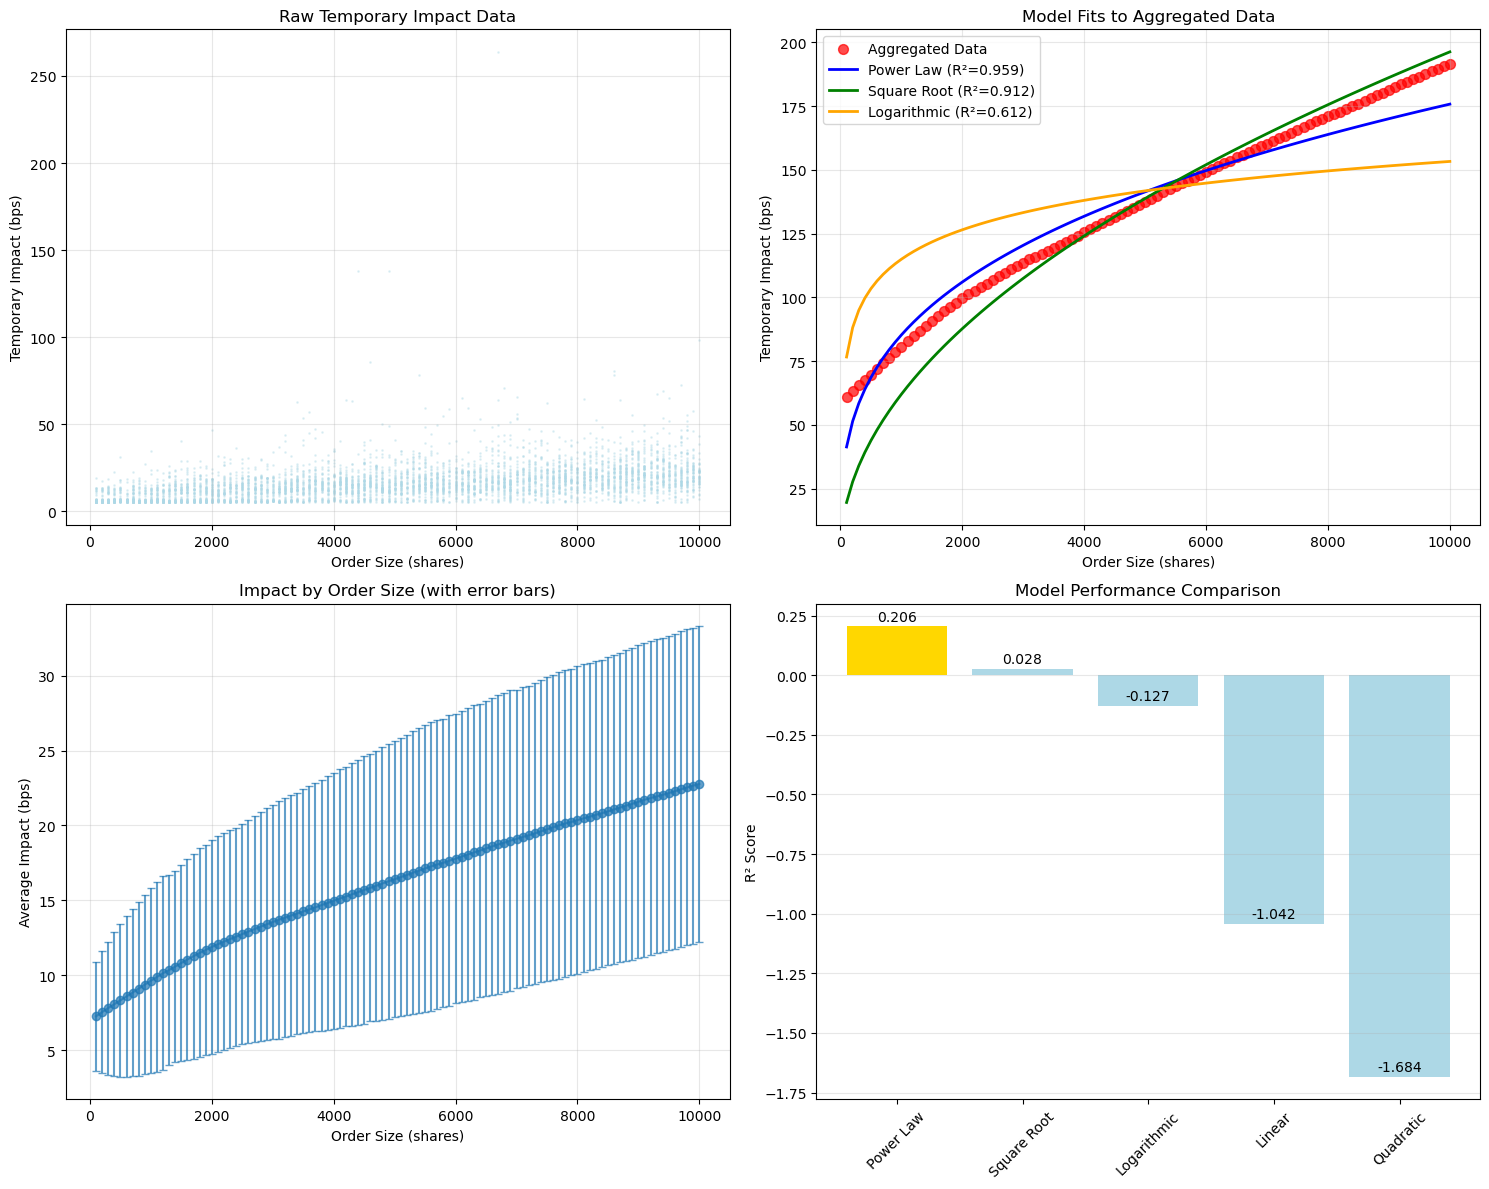

In [12]:
print(f"\n{section_num + 2}. FINAL MODEL TRAINING ON ALL DATA")
print("-" * 40)

# Use all reliable data for final model training
final_agg = reliable_impact.groupby('order_size')['impact_mean'].mean().reset_index()
X_final = final_agg['order_size'].values
y_final = final_agg['impact_mean'].values

print(f"✓ Training final models on {len(X_final)} order sizes with aggregated data")

final_models = {}
for model_type in model_types:
    result = fit_impact_model(X_final, y_final, model_type)
    if result is not None:
        final_models[model_type] = result
        print(f"  {model_type:12s}: R² = {result['r2']:.4f}, MSE = {result['mse']:.2e}")

# --------------------------
# MODEL COMPARISON AND SELECTION
# --------------------------
print(f"\n{section_num + 3}. MODEL COMPARISON AND RESULTS")
print("-" * 40)

# Rank models
model_rankings = []

if use_cross_validation and any(cv_results[mt]['r2_scores'] for mt in model_types):
    print("Cross-Validation Performance:")
    print("Model        | CV R² (Mean±Std) | Final R² | Recommended")
    print("-" * 60)
    
    for model_type in model_types:
        r2_scores = cv_results[model_type]['r2_scores']
        if r2_scores and model_type in final_models:
            cv_r2_mean = np.mean(r2_scores)
            cv_r2_std = np.std(r2_scores)
            final_r2 = final_models[model_type]['r2']
            
            model_rankings.append((model_type, cv_r2_mean, cv_r2_std, final_r2))
            
    model_rankings.sort(key=lambda x: x[1], reverse=True)  # Sort by CV R²
    
    for i, (model_type, cv_r2, cv_std, final_r2) in enumerate(model_rankings):
        recommended = "★" if i == 0 else " "
        print(f"{model_type:12s} | {cv_r2:6.3f}±{cv_std:5.3f} | {final_r2:8.4f} | {recommended}")

else:
    print("Single Dataset Performance (no cross-validation):")
    print("Model        | R²       | MSE      | Formula Preview")
    print("-" * 65)
    
    for model_type in model_types:
        if model_type in final_models:
            result = final_models[model_type]
            formula_preview = result['formula'][:45] + "..." if len(result['formula']) > 45 else result['formula']
            model_rankings.append((model_type, result['r2'], 0, result['r2']))
            print(f"{model_type:12s} | {result['r2']:8.4f} | {result['mse']:.2e} | {formula_preview}")
    
    model_rankings.sort(key=lambda x: x[1], reverse=True)

# --------------------------
# GENERATE ANALYSIS PLOTS
# --------------------------
print(f"\n{section_num + 4}. GENERATING VISUALIZATION")
print("-" * 40)

try:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Raw impact data scatter
    sample_impact = impact_df.sample(n=min(5000, len(impact_df)))
    ax1.scatter(sample_impact['order_size'], sample_impact['impact_bps'], 
                alpha=0.3, s=1, color='lightblue')
    ax1.set_xlabel('Order Size (shares)')
    ax1.set_ylabel('Temporary Impact (bps)')
    ax1.set_title('Raw Temporary Impact Data')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Aggregated impact with model fits
    if len(final_agg) > 0:
        ax2.scatter(final_agg['order_size'], final_agg['impact_mean'] * 10000, 
                   color='red', s=50, alpha=0.7, label='Aggregated Data')
        
        # Plot best models
        x_smooth = np.linspace(final_agg['order_size'].min(), final_agg['order_size'].max(), 100)
        
        colors = ['blue', 'green', 'orange', 'purple', 'brown']
        for i, (model_type, _, _, _) in enumerate(model_rankings[:3]):  # Plot top 3 models
            if model_type in final_models:
                result = final_models[model_type]
                
                if model_type == 'Linear':
                    y_smooth = result['params']['beta'] * x_smooth * 10000
                elif model_type == 'Square Root':
                    y_smooth = result['params']['beta'] * np.sqrt(x_smooth) * 10000
                elif model_type == 'Power Law':
                    y_smooth = result['params']['beta'] * (x_smooth ** result['params']['alpha']) * 10000
                elif model_type == 'Quadratic':
                    y_smooth = (result['params']['beta1'] * x_smooth + 
                              result['params']['beta2'] * (x_smooth ** 2)) * 10000
                elif model_type == 'Logarithmic':
                    y_smooth = result['params']['beta'] * np.log(x_smooth) * 10000
                
                ax2.plot(x_smooth, y_smooth, color=colors[i], linewidth=2, 
                        label=f"{model_type} (R²={result['r2']:.3f})")
        
        ax2.set_xlabel('Order Size (shares)')
        ax2.set_ylabel('Temporary Impact (bps)')
        ax2.set_title('Model Fits to Aggregated Data')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Impact by order size distribution
    size_impact = impact_df.groupby('order_size')['impact_bps'].agg(['mean', 'std', 'count'])
    size_impact = size_impact[size_impact['count'] >= 5]  # Filter for reliability
    
    ax3.errorbar(size_impact.index, size_impact['mean'], yerr=size_impact['std'], 
                fmt='o-', capsize=3, alpha=0.7)
    ax3.set_xlabel('Order Size (shares)')
    ax3.set_ylabel('Average Impact (bps)')
    ax3.set_title('Impact by Order Size (with error bars)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Model comparison
    if model_rankings:
        model_names = [x[0] for x in model_rankings]
        model_r2s = [x[1] for x in model_rankings]
        
        bars = ax4.bar(range(len(model_names)), model_r2s, color=['gold' if i == 0 else 'lightblue' 
                                                                 for i in range(len(model_names))])
        ax4.set_xticks(range(len(model_names)))
        ax4.set_xticklabels(model_names, rotation=45)
        ax4.set_ylabel('R² Score')
        ax4.set_title('Model Performance Comparison')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, r2 in zip(bars, model_r2s):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{r2:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(PLOT_OUTPUT, dpi=300, bbox_inches='tight')
    print(f"✓ Plots saved to {PLOT_OUTPUT}")
    
except Exception as e:
    print(f"⚠ Warning: Could not generate plots: {e}")